In [9]:
import base64
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import json
import seaborn as sns
import re

pp = pprint.PrettyPrinter(indent=4)

In [ ]:
remove_negative_gaze = False

filter_blacklist = True
blacklist = ['rita_10-02-2025-2']
# df = pd.read_csv('data/experiment_results_public_lab.csv')
df = pd.read_csv('data/experiment_results_public_add_cal.csv')
df2 = pd.read_csv('data/experiment_results_local_add_cal.csv')
df2 = df2[df2['timestamp'] == '04-Feb-2025 12:50:17']
df = pd.concat([df, df2], axis=0)
df = df.drop('type', axis=1)

if filter_blacklist:
    df = df[~df.workerid.isin(blacklist)]

# reindex the df
df.reset_index(drop=True, inplace=True)

def parse(data):
    while data[0] != '{':
        data = data[1:]
    while data[-1] != '}':
        data = data[:-1]
    data = data.replace('\\', '')
    data = re.sub(
        r'(?<=strategy":")(.*)(?="\})',
        lambda m: m.group(0).replace('"', '\\"'),
        data,
        count=1)
    json_data = {}
    try:
        json_data = json.loads(data)
    except:
        pp.pprint(data[-200:])
    return json_data

df = pd.concat([df, pd.json_normalize(df.apply(lambda x: parse(x['answer']), axis=1, ), max_level=0)], axis=1)

if remove_negative_gaze:
    df.gaze = df.gaze.apply(lambda x: {key:val for key, val in json.loads(base64.b64decode(x)).items() if int(key) > 0})
else:
    df.gaze = df.gaze.apply(lambda x: json.loads(base64.b64decode(x)))
df.sort_values(by=['workerid', 'userTrialId'], inplace=True)
df.reset_index(drop=True, inplace=True)
df['deviceInfo'] = df['deviceInfo'].ffill()
df.columns

Index(['filename', 'listnumber', 'assignmentid', 'hitid', 'workerid', 'origin',
       'timestamp', 'partid', 'questionid', 'answer', 'trialid', 'sentmsg',
       'trgt', 'comp', 'dist', 'msg1', 'msg2', 'msg3', 'msg4', 'id',
       'sent_msg', 'objs', 'trgtPos', 'compPos', 'distPos', 'type',
       'msgsOrder', 'userTrialId', 'answerTime', 'choicePos', 'choice',
       'coordinates', 'gaze', 'correct', 'deviceInfo', 'calibrationPrecision',
       'techDiffs', 'otherComments', 'strategy'],
      dtype='object')

In [11]:
df['workerid'].unique()

array(['iza_test3_11february', 'j', 'jack_0402', 'rita_12-02-2025-1'],
      dtype=object)

### Convert Gaze to Fixation detection format
#### After consideration, fixation detection does not seem like a good choice for our data

In [12]:
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# for participant in df['workerid'].unique():
#     participant_df = df[df['workerid'] == participant]
#     participant_df.reset_index(drop=True, inplace=True)
#     x = participant_df['gaze'].apply(lambda gaze: [gaze[key]['x'] for key in gaze.keys()])
#     y = participant_df['gaze'].apply(lambda gaze: [gaze[key]['y'] for key in gaze.keys()])
#     time = participant_df['gaze'].apply(lambda gaze: [int(key) for key in gaze.keys()])
#     # shift all values to remove negative values
#     time = time.apply(lambda x: [i - min(x) for i in x])
#     prep_df = pd.DataFrame({'trial': participant_df['userTrialId'],'x': x, 'y': y, 'time': time})
#     prep_df = prep_df.explode(['x','y','time'])
#     prep_df.sort_values(by=['trial', 'time'], inplace=True)
#     prep_df.to_csv(f'data/participants_raw_gaze/{participant}.csv', index=False)

# import subprocess
# subprocess.call("/usr/bin/Rscript --vanilla ~/uds/thesis/Thesis-Project/analysis/fixations.r", shell=True)

# for participant in df['workerid'].unique():
#     participant_fixations = pd.read_csv(f'data/participants_fixations/{participant}.csv')

#     fixations = participant_fixations.groupby('trial').apply(lambda x: x.to_dict(orient='records')).to_dict()
#     print(fixations)
#     df.loc[df['workerid'] == participant, 'fixations'] = df[df['workerid'] == participant]['userTrialId'].apply(lambda x: fixations[x] if x in fixations else [])
    

## Gen Features

{   'available_msgs': {'height': 100, 'width': 400, 'x': 724, 'y': 749},
    'img1': {'height': 200, 'width': 200, 'x': 280, 'y': 372},
    'img2': {'height': 200, 'width': 200, 'x': 824, 'y': 372},
    'img3': {'height': 200, 'width': 200, 'x': 1368, 'y': 372},
    'msg1': {'height': 100, 'width': 100, 'x': 724, 'y': 749},
    'msg2': {'height': 100, 'width': 100, 'x': 824, 'y': 749},
    'msg3': {'height': 100, 'width': 100, 'x': 924, 'y': 749},
    'msg4': {'height': 100, 'width': 100, 'x': 1024, 'y': 749},
    'sent_msg': {'height': 100, 'width': 100, 'x': 1016, 'y': 122}}
First row of new features

timeOnSentMsg                      8
timeOnSentMsgSimple              NaN
timeOnSentMsgComplex             NaN
timeOnSentMsgUnambiguous         8.0
timeOnAvailableMsgs               23
timeOnImg1                        18
timeOnImg2                        34
timeOnImg3                        34
timeOnTrgt                        18
timeOnTrgtSimple                 NaN
timeOnTrgtComplex  

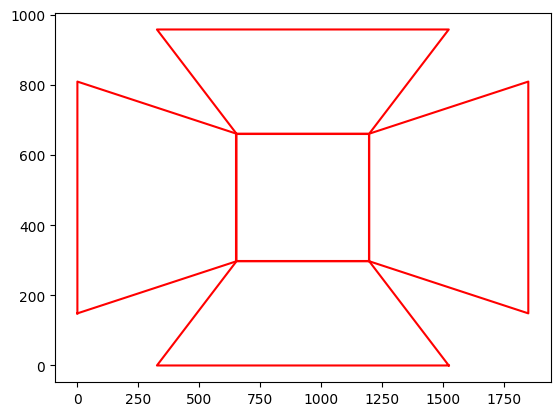

In [19]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


df['meanAnswerTime'] = df.groupby('workerid')['answerTime'].transform('mean')
df['answerAccuracy'] = df.groupby('workerid')['correct'].transform('mean')
df['answerAccuracySimple'] = df[df['type'].isin(['simple','strategy_simple'])].groupby('workerid')['correct'].transform('mean')
df['answerAccuracyComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].groupby('workerid')['correct'].transform('mean')
df['answerAccuracyUnambiguous'] = df[df['type'] == 'unambiguous'].groupby('workerid')['correct'].transform('mean')
df['resolution'] = df.deviceInfo.apply(lambda x: [int(size) for size in x['screen'].split('x')])

use_fixations = False
# margin for gaze objects
res_w_x = 0.0
res_w_y = 0.0

first_ploted = False
plot_first = False

if plot_first:
    resolution = df.iloc[0].resolution
    pp.pprint(df.iloc[0].deviceInfo)
    pp.pprint(resolution)
    plt.figure(figsize=(resolution[0]*6/resolution[1], 6))
    plt.xlim(0, resolution[0])
    plt.ylim(0, resolution[1])
    if use_fixations:
        for fixation in df.iloc[0].fixations:
            plt.plot(fixation['x'], fixation['y'], 'bo')
    else:
        for _, val in df.iloc[0].gaze.items():
                plt.plot(val['x'], val['y'], 'bo')


def compute_polygon(polygon_type, coords):
    x12 = (coords['img1']['x'] + coords['img1']['width'] + coords['img2']['x'])/2
    x23 = (coords['img2']['x'] + coords['img2']['width'] + coords['img3']['x'])/2
    y12 = (coords['sent_msg']['y'] + coords['sent_msg']['height'] + coords['img1']['y'])/2
    y23 = (coords['img1']['y'] + coords['img1']['height'] + coords['available_msgs']['y'])/2
    match polygon_type:
        case 'sent_msg':
            return Polygon([(x23+x12/2, 0), (x12/2, 0), (x12, y12), (x23, y12)])
        case 'img1':
            return Polygon([(0, y12/2), (x12, y12), (x12, y23), (0, y23+y12/2)])
        case 'img2':
            return Polygon([(x12, y12), (x23, y12), (x23, y23), (x12, y23)])
        case 'img3':
            return Polygon([(x23, y12), (x12+x23, y12/2), (x12+x23, y23+y12/2), (x23, y23)])
        case 'available_msgs':
            return Polygon([(x12, y23), (x23, y23), (x23+x12/2, y12+y23), (x12/2, y12+y23)])


def count_gaze(gaze, polygon, plot_first = plot_first):
    global first_ploted
    x,y = polygon.exterior.xy
    if plot_first and not first_ploted:
        plt.plot(x, y, 'r')
        first_ploted = True
    count = 0
    for _, val in gaze.items():
        point = Point(val['x'], val['y'])
        if polygon.contains(point):
            count += 1
    return count


def plot_polygons(coords, plot):
    aoi = ['sent_msg', 'img1', 'img2', 'img3', 'available_msgs']
    for polygon_type in aoi:
        polygon = compute_polygon(polygon_type, coords)
        x,y = polygon.exterior.xy
        plot.plot(x, y, 'r')

def merge_msgs_coords(coords):
    coords['available_msgs'] = {'height': coords['msg1']['height'], 'width': coords['msg4']['x'] + coords['msg4']['width'] - coords['msg1']['x'], 'x': coords['msg1']['x'], 'y': coords['msg1']['y']}
    return coords

df['coordinates'] = df.apply(lambda x: merge_msgs_coords(x['coordinates']), axis=1)
pp.pprint(df.iloc[0].coordinates)

df['timeOnSentMsg'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('sent_msg', x['coordinates']), x['resolution']), axis=1) 
df['timeOnSentMsgSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x['timeOnSentMsg'], axis=1)
df['timeOnSentMsgComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x['timeOnSentMsg'], axis=1)
df['timeOnSentMsgUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x['timeOnSentMsg'], axis=1)
first_ploted = False
df['timeOnAvailableMsgs'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('available_msgs', x['coordinates']), x['resolution']), axis=1)
df['timeOnAvailableMsgsSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x['timeOnAvailableMsgs'], axis=1)
df['timeOnAvailableMsgsComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x['timeOnAvailableMsgs'], axis=1)
df['timeOnAvailableMsgsUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x['timeOnAvailableMsgs'], axis=1)
first_ploted = False
df['timeOnImg1'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('img1', x['coordinates']), x['resolution']), axis=1)
first_ploted = False
df['timeOnImg2'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('img2', x['coordinates']), x['resolution']), axis=1)
first_ploted = False
df['timeOnImg3'] = df.apply(lambda x: count_gaze(x['gaze'], compute_polygon('img3', x['coordinates']), x['resolution']), axis=1)
df['timeOnTrgt'] = df.apply(lambda x: x[('timeOnImg' + str(1 + x['trgtPos']))], axis=1)
df['timeOnTrgtSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x[('timeOnImg' + str(1 + x['trgtPos']))], axis=1)
df['timeOnTrgtComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x[('timeOnImg' + str(1 + x['trgtPos']))], axis=1)
df['timeOnTrgtUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x[('timeOnImg' + str(1 + x['trgtPos']))], axis=1)
df['timeOnDist'] = df.apply(lambda x: x[('timeOnImg' + str(1 + x['distPos']))], axis=1)
df['timeOnDistSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x[('timeOnImg' + str(1 + x['distPos']))], axis=1)
df['timeOnDistComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x[('timeOnImg' + str(1 + x['distPos']))], axis=1)
df['timeOnDistUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x[('timeOnImg' + str(1 + x['distPos']))], axis=1)
df['timeOnComp'] = df.apply(lambda x: x[('timeOnImg' + str(1 + x['compPos']))], axis=1)
df['timeOnCompSimple'] = df[df['type'].isin(['simple','strategy_simple'])].apply(lambda x: x[('timeOnImg' + str(1 + x['compPos']))], axis=1)
df['timeOnCompComplex'] = df[df['type'].isin(['complex', 'strategy_complex'])].apply(lambda x: x[('timeOnImg' + str(1 + x['compPos']))], axis=1)
df['timeOnCompUnambiguous'] = df[df['type'] == 'unambiguous'].apply(lambda x: x[('timeOnImg' + str(1 + x['compPos']))], axis=1)
df['timeOnAOI'] = df.apply(lambda x: sum(x[['timeOnSentMsg', 'timeOnAvailableMsgs', 'timeOnImg1', 'timeOnImg2', 'timeOnImg3']]), axis=1)
df['timeOnTrial'] = df.apply(lambda x: len(x['gaze']), axis=1)
df['timeOnNonAOI'] = df.apply(lambda x: x['timeOnTrial'] - x['timeOnAOI'], axis=1)
df['timeOnNonAOISimple'] = df.apply(lambda x: x['timeOnTrial'] - sum(x[['timeOnSentMsgSimple', 'timeOnAvailableMsgsSimple', 'timeOnTrgtSimple', 'timeOnCompSimple', 'timeOnDistSimple']]), axis=1)
df['timeOnNonAOIComplex'] = df.apply(lambda x: x['timeOnTrial'] - sum(x[['timeOnSentMsgComplex', 'timeOnAvailableMsgsComplex', 'timeOnTrgtComplex', 'timeOnCompComplex', 'timeOnDistComplex']]), axis=1)
df['timeOnNonAOIUnambiguous'] = df.apply(lambda x: x['timeOnTrial'] - sum(x[['timeOnSentMsgUnambiguous', 'timeOnAvailableMsgsUnambiguous', 'timeOnTrgtUnambiguous', 'timeOnCompUnambiguous', 'timeOnDistUnambiguous']]), axis=1)
df['propTimeOnNonAOI'] = df['timeOnNonAOI'] / df['timeOnTrial']
df['propTimeOnNonAOISimple'] = df['timeOnNonAOISimple'] / df['timeOnTrial']
df['propTimeOnNonAOIComplex'] = df['timeOnNonAOIComplex'] / df['timeOnTrial']
df['propTimeOnNonAOIUnambiguous'] = df['timeOnNonAOIUnambiguous'] / df['timeOnTrial']
df['propTimeOnSentMsg'] = df['timeOnSentMsg'] / df['timeOnTrial']
df['propTimeOnSentMsgSimple'] = df['timeOnSentMsgSimple'] / df['timeOnTrial']
df['propTimeOnSentMsgComplex'] = df['timeOnSentMsgComplex'] / df['timeOnTrial']
df['propTimeOnSentMsgUnambiguous'] = df['timeOnSentMsgUnambiguous'] / df['timeOnTrial']
df['propTimeOnAvailableMsgs'] = df['timeOnAvailableMsgs'] / df['timeOnTrial']
df['propTimeOnAvailableMsgsSimple'] = df['timeOnAvailableMsgsSimple'] / df['timeOnTrial']
df['propTimeOnAvailableMsgsComplex'] = df['timeOnAvailableMsgsComplex'] / df['timeOnTrial']
df['propTimeOnAvailableMsgsUnambiguous'] = df['timeOnAvailableMsgsUnambiguous'] / df['timeOnTrial']
df['propTimeOnTrgt'] = df['timeOnTrgt'] / df['timeOnTrial']
df['propTimeOnTrgtSimple'] = df['timeOnTrgtSimple'] / df['timeOnTrial']
df['propTimeOnTrgtComplex'] = df['timeOnTrgtComplex'] / df['timeOnTrial']
df['propTimeOnTrgtUnambiguous'] = df['timeOnTrgtUnambiguous'] / df['timeOnTrial']
df['propTimeOnDist'] = df['timeOnDist'] / df['timeOnTrial']
df['propTimeOnDistSimple'] = df['timeOnDistSimple'] / df['timeOnTrial']
df['propTimeOnDistComplex'] = df['timeOnDistComplex'] / df['timeOnTrial']
df['propTimeOnDistUnambiguous'] = df['timeOnDistUnambiguous'] / df['timeOnTrial']
df['propTimeOnComp'] = df['timeOnComp'] / df['timeOnTrial']
df['propTimeOnCompSimple'] = df['timeOnCompSimple'] / df['timeOnTrial']
df['propTimeOnCompComplex'] = df['timeOnCompComplex'] / df['timeOnTrial']
df['propTimeOnCompUnambiguous'] = df['timeOnCompUnambiguous'] / df['timeOnTrial']

msg_type = {'ci': 'shape',
            'sq': 'shape',
            'tr': 'shape',
            'bl': 'color',
            're': 'color',
            'gr': 'color'}
df['msgType'] = df['sent_msg'].map(msg_type)

df['condition'] = df['type'].map({'simple': 'simple', 'complex': 'complex', 'strategy_simple': 'simple', 'strategy_complex': 'complex', 'unambiguous': 'unambiguous'})

if plot_first:
    plt.gca().invert_yaxis()
    plt.show()

print("First row of new features\n")
pp.pprint(df.iloc[0][['timeOnSentMsg', 'timeOnSentMsgSimple', 'timeOnSentMsgComplex', 'timeOnSentMsgUnambiguous', 'timeOnAvailableMsgs', 'timeOnImg1', 'timeOnImg2', 'timeOnImg3', 'timeOnTrgt', 'timeOnTrgtSimple', 'timeOnTrgtComplex', 'timeOnTrgtUnambiguous', 'timeOnDist', 'timeOnComp', 'distPos', 'trgtPos', 'compPos', 'timeOnAOI', 'propTimeOnSentMsg', 'propTimeOnAvailableMsgs', 'propTimeOnTrgt', 'propTimeOnDist', 'propTimeOnComp']])

## Explode Gaze and Create CSV

In [22]:
gaze_df = df[['workerid', 'userTrialId', 'type', 'correct', 'answerTime', 'gaze', 'trgtPos', 'distPos', 'compPos', 'coordinates', 'condition', 'msgType']]

def detect_aoi(point, coords):
    for aoi in ['sent_msg', 'img1', 'img2', 'img3', 'available_msgs']:
        polygon = compute_polygon(aoi, coords)
        if polygon.contains(point):
            return aoi
    return 'non_aoi'

def explode_gaze(row):
    x = []
    y = []
    time = []
    aois = []
    subject = row['workerid']
    trial = row['userTrialId']
    condition = row['type']
    msg_type = row['msgType']
    trgt_pos = row['trgtPos']
    for key, val in row['gaze'].items():
        x.append(val['x'])
        y.append(val['y'])
        time.append(int(key))
        point = Point(val['x'], val['y'])
        img_to_obj = {row['trgtPos'] : 'trgt', row['distPos'] : 'dist', row['compPos'] : 'comp'}
        aoi = detect_aoi(point, row['coordinates'])
        if aoi in ['img1', 'img2', 'img3']:
            aoi = img_to_obj[int(aoi[-1])-1]
        aois.append(aoi)
    return pd.DataFrame({'Subject': subject, 'Trial': trial, 'Condition': condition, 'MsgType': msg_type, 'TrgtPos': trgt_pos, 'Time': time, 'AOI': aois})
# np.array(gaze_df.apply(lambda x: explode_gaze(x), axis=1)).flatten()
pd.concat(np.array(gaze_df.apply(lambda x: explode_gaze(x), axis=1)).flatten(), axis=0).to_csv('data/gaze.csv', index=False)

# Final Feature CSV per Trial

In [7]:
final_df_features = ['workerid',
                     'userTrialId',
                     'type',
                     'correct',
                     'answerTime',
                     'propTimeOnSentMsg',
                     'propTimeOnTrgt',
                     'propTimeOnDist',
                     'propTimeOnComp',
                     'propTimeOnAvailableMsgs',
                     'propTimeOnNonAOI',
                     'trgtPos',
                     'msgType'
                    ]
final_df = df[final_df_features]
final_df = final_df.rename(columns={'workerid': 'Subject',
                                    'userTrialId': 'Trial',
                                    'type': 'Condition',
                                    'correct': 'Correct',
                                    'answerTime': 'AnswerTime',
                                    'propTimeOnSentMsg': 'PropTimeOnSentMsg',
                                    'propTimeOnTrgt': 'PropTimeOnTrgt',
                                    'propTimeOnDist': 'PropTimeOnDist',
                                    'propTimeOnComp': 'PropTimeOnComp',
                                    'propTimeOnAvailableMsgs': 'PropTimeOnAvailableMsgs',
                                    'propTimeOnNonAOI': 'PropTimeOnNonAOI',
                                    'trgtPos': 'TargetPosition',
                                    'msgType': 'MsgType'})
final_df.to_csv('data/final_trial_df.csv', index=False)
final_df.head()

,Subject,Trial,Condition,Correct,AnswerTime,PropTimeOnSentMsg,PropTimeOnTrgt,PropTimeOnDist,PropTimeOnComp,PropTimeOnAvailableMsgs,PropTimeOnNonAOI,TargetPosition,MsgType
0,iza_test3_11february,0,unambiguous,1,9108,0.059259,0.133333,0.251852,0.251852,0.170370,0.133333,0,shape
1,iza_test3_11february,1,unambiguous,1,2977,0.461538,0.000000,0.230769,0.076923,0.076923,0.153846,0,color
2,iza_test3_11february,2,complex,1,10220,0.026316,0.157895,0.184211,0.184211,0.144737,0.302632,2,color
3,iza_test3_11february,3,complex,1,5943,0.170213,0.085106,0.382979,0.276596,0.000000,0.085106,0,color
4,iza_test3_11february,4,complex,1,13538,0.077922,0.000000,0.000000,0.636364,0.285714,0.000000,2,shape


## Final Feature CSV per Participant

In [6]:
final_df_features = ['propTimeOnSentMsg',
                        'propTimeOnSentMsgSimple',
                        'propTimeOnSentMsgComplex',
                        'propTimeOnSentMsgUnambiguous',
                        'propTimeOnAvailableMsgs',
                        'propTimeOnAvailableMsgsSimple',
                        'propTimeOnAvailableMsgsComplex',
                        'propTimeOnAvailableMsgsUnambiguous',
                        'propTimeOnTrgt',
                        'propTimeOnTrgtSimple',
                        'propTimeOnTrgtComplex',
                        'propTimeOnTrgtUnambiguous',
                        'propTimeOnDist',
                        'propTimeOnDistSimple',
                        'propTimeOnDistComplex',
                        'propTimeOnDistUnambiguous',
                        'propTimeOnComp',
                        'propTimeOnCompSimple',
                        'propTimeOnCompComplex',
                        'propTimeOnCompUnambiguous',
                        'propTimeOnNonAOISimple',
                        'propTimeOnNonAOIComplex',
                        'propTimeOnNonAOIUnambiguous',
                        'meanAnswerTime',
                        'answerAccuracySimple',
                        'answerAccuracyComplex',
                        'answerAccuracyUnambiguous'
                     ]
final_df = df.groupby('workerid')[final_df_features].mean()
final_df['calibrationPrecision'] = df.groupby('workerid')['calibrationPrecision'].first()

# Save the final df
final_df.to_csv('data/final_participant_df.csv')
final_df.head()

,propTimeOnSentMsg,propTimeOnSentMsgSimple,propTimeOnSentMsgComplex,propTimeOnSentMsgUnambiguous,propTimeOnAvailableMsgs,propTimeOnAvailableMsgsSimple,propTimeOnAvailableMsgsComplex,propTimeOnAvailableMsgsUnambiguous,propTimeOnTrgt,propTimeOnTrgtSimple,...,propTimeOnCompComplex,propTimeOnCompUnambiguous,propTimeOnNonAOISimple,propTimeOnNonAOIComplex,propTimeOnNonAOIUnambiguous,meanAnswerTime,answerAccuracySimple,answerAccuracyComplex,answerAccuracyUnambiguous,calibrationPrecision
workerid,,,,,,,,,,,,,,,,,,,,,
Laura,0.344389,0.163972,0.367361,0.541194,0.025695,0.028016,0.038667,0.006579,0.220852,0.232009,...,0.180193,0.015306,0.131611,0.148128,0.113528,9484.285714,1.0,1.0,1.0,"[86, 76, 85]"
Olha,0.071939,0.065163,0.013123,0.153930,0.120706,0.096224,0.225206,0.020683,0.323867,0.358277,...,0.205870,0.103675,0.057864,0.075218,0.048015,37141.214286,1.0,1.0,1.0,"[72, 84, 68]"
merel,0.167814,0.141974,0.122992,0.256142,0.107283,0.100984,0.151950,0.059324,0.142648,0.143595,...,0.248829,0.117424,0.169571,0.224414,0.225652,7431.071429,0.8,1.0,1.0,"[50, 49, 70]"
test_ee,0.164712,0.151550,0.175390,0.167818,0.125119,0.087106,0.215597,0.059539,0.265675,0.380872,...,0.257626,0.101220,0.021922,0.053045,0.005814,7021.571429,1.0,1.0,1.0,"[79, 49, 61]"
test_iza,0.089030,0.090635,0.050308,0.135428,0.313143,0.378163,0.410326,0.110390,0.205993,0.132537,...,0.215191,0.044889,0.022845,0.021648,0.010709,11653.642857,1.0,0.8,1.0,"[78, 78, 74]"


### Fitting Some Regressions

[0.73932876 0.09287049 0.06902342 0.04614951 0.03279965 0.01982818]


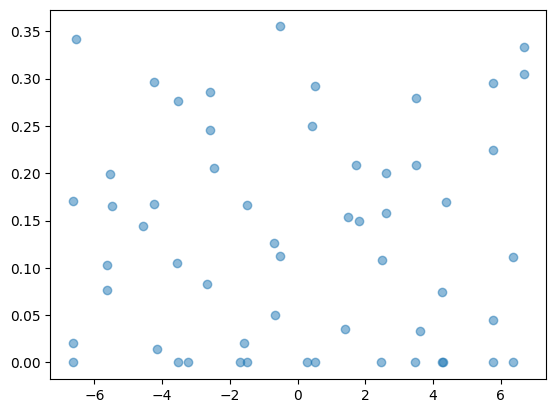

In [ ]:
import math

def logit(x):
    odds = x/(1-x)
    if (x/1-x) >= 1:
        odds -= 1e-10
    elif (x/1-x) <= 0:
        odds += 1e-3
    return math.log(odds)

fit_df = pd.read_csv('data/final_trial_df.csv')


features = ['TrgtPosLeftRight', 'TrgtPosMiddle', 'Trial', 'MsgColorShape', 'SimpleComplex', 'Unambiguous']
# code 3 conditions into 2 columns of binary values

code = [[ 1, -1],
        [-1, -1],
        [ 0,  2]]

simple_vs_complex = {'simple': 1, 'complex': -1, 'unambiguous': 0, 'strategy_simple': 1, 'strategy_complex': -1}
left_vs_right = [1, 0, -1]
color_vs_shape = {'color': 1, 'shape': -1}
fit_df['TrgtPosLeftRight'] = fit_df['TargetPosition'].apply(lambda x: left_vs_right[x])
fit_df['TrgtPosMiddle'] = fit_df['TargetPosition'].apply(lambda x: 2 if x == 1 else -1)
fit_df['MsgColorShape'] = fit_df['MsgType'].map(color_vs_shape)
fit_df['SimpleComplex'] = fit_df['Condition'].map(simple_vs_complex)
fit_df['Unambiguous'] = fit_df['Condition'].apply(lambda x: 2 if x == 'unambiguous' else -1)
fit_df['PropTimeOnAvailableMsgsLog'] = fit_df['PropTimeOnAvailableMsgs'].apply(lambda x: logit(x))
fit_df['Trial'] = fit_df['Trial']-fit_df['Trial'].median()

x = fit_df[features]
y = fit_df['PropTimeOnAvailableMsgs']

fit_df[['PropTimeOnAvailableMsgsLog', 'PropTimeOnAvailableMsgs']].head()

# apply pca and report the explained variance
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x)
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

# plot first principal component against target variable
pca = PCA(n_components=1)
pca.fit(x)
x_pca = pca.transform(x)
plt.scatter(x_pca, y)



In [25]:

# fit linear regression and report correlation of features to target
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x, y)
y_pred = reg.predict(x)

coefs = np.array([features, reg.coef_]).T
print(reg.score(x, y))
print(coefs)

# # plot feature and mmodel predictions for each feature
# for feature in features:
#     plt.figure()
#     sns.scatterplot(x=fit_df[feature], y=fit_df['PropTimeOnAvailableMsgs'])
#     sns.lineplot(x=fit_df[feature], y=y_pred)


0.09889705347121003
[['TrgtPosLeftRight' '0.195964094506491']
 ['TrgtPosMiddle' '0.26409713334823387']
 ['Trial' '-0.07364645705117706']
 ['MsgColorShape' '0.09706406755204097']
 ['SimpleComplex' '-0.3035098453421854']
 ['Unambiguous' '-0.3594961067937925']]


  Subject  Trial    Condition  Correct  AnswerTime  PropTimeOnSentMsg  \
0       j   -6.5  unambiguous        1        5222           0.333333   
1       j   -5.5      complex        0       23658           0.334294   
2       j   -4.5      complex        1       17416           0.280000   
3       j   -3.5      complex        1        9275           0.240000   
4       j   -2.5       simple        1       14802           0.145729   

   PropTimeOnTrgt  PropTimeOnDist  PropTimeOnComp  PropTimeOnAvailableMsgs  \
0        0.121212        0.363636        0.181818                 0.000000   
1        0.089337        0.126801        0.149856                 0.198847   
2        0.172000        0.108000        0.216000                 0.168000   
3        0.408000        0.200000        0.000000                 0.000000   
4        0.256281        0.190955        0.150754                 0.206030   

   PropTimeOnNonAOI  TargetPosition MsgType  TrgtPosLeftRight  TrgtPosMiddle  \
0          0

/home/gatemrou/venvs/ml2024/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/home/gatemrou/venvs/ml2024/lib/python3.12/site-packages/pymer4/models/Lmer.py:744: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_corrs = ran_corrs.applymap(


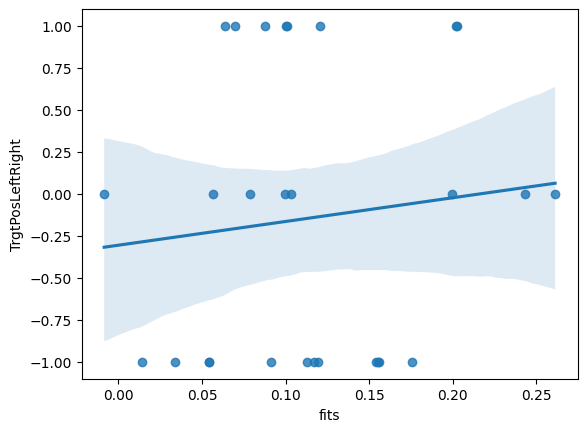

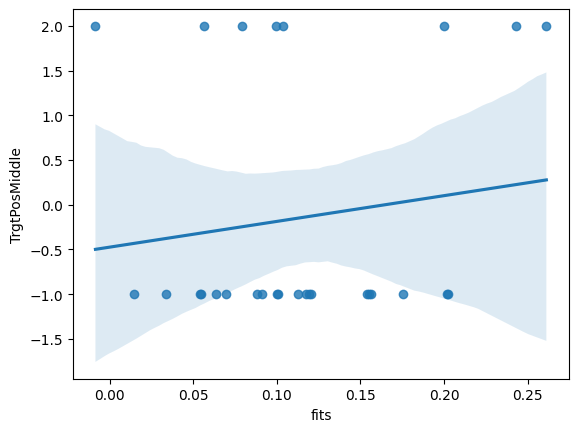

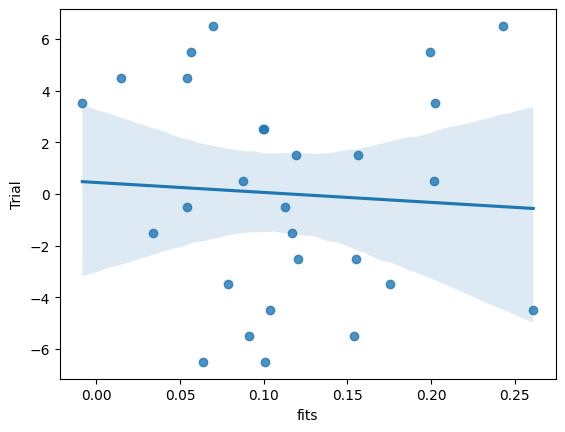

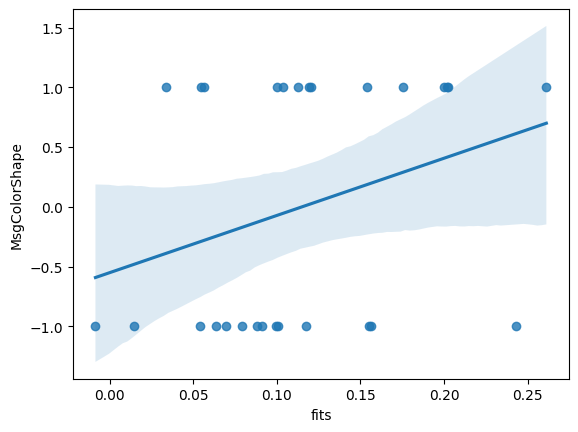

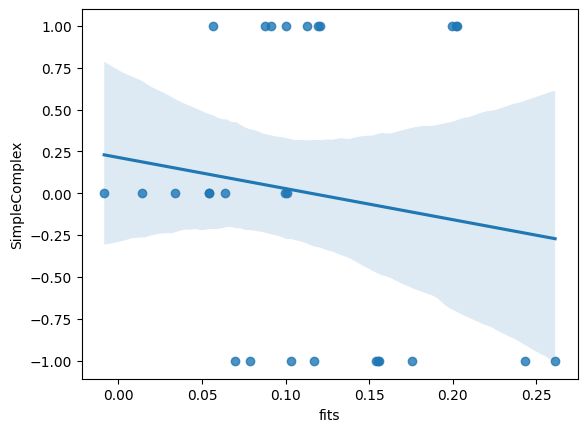

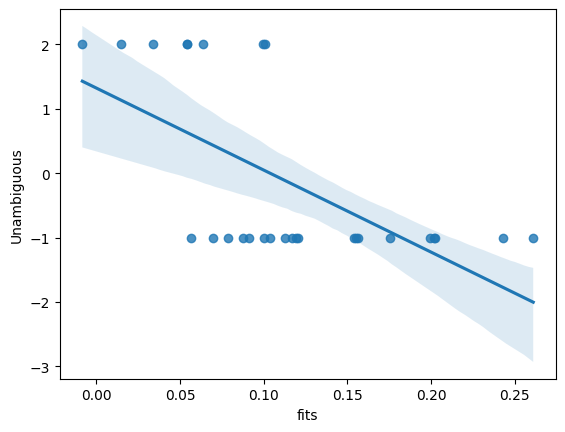

In [ ]:

from pymer4.models import Lmer

print(fit_df.head())
reg = Lmer('PropTimeOnAvailableMsgsLog ~ TrgtPosLeftRight + TrgtPosMiddle + MsgColorShape + SimpleComplex + Unambiguous + Trial + (1 + TrgtPosLeftRight + TrgtPosMiddle + SimpleComplex + Unambiguous + Trial|Subject)', data=fit_df)
print(reg.fit())

# plot feature and mmodel predictions for each feature
for feature in features:
    plt.figure()
    sns.regplot(x='fits', y=feature, data=reg.data, fit_reg=True)



In [ ]:
# print(sum([df['propTimeOnNonAOIUnambiguous'].mean(), df['propTimeOnSentMsgUnambiguous'].mean(), df['propTimeOnTrgtUnambiguous'].mean(), df['propTimeOnDistUnambiguous'].mean(), df['propTimeOnCompUnambiguous'].mean()], df['propTimeOnAvailableMsgsUnambiguous'].mean()))
print(df['propTimeOnTrgtComplex'].mean(), df['propTimeOnTrgtSimple'].mean(), df['propTimeOnTrgtUnambiguous'].mean(), df['propTimeOnTrgt'].mean())
df[['propTimeOnTrgtComplex', 'propTimeOnTrgtSimple', 'propTimeOnTrgtUnambiguous', 'propTimeOnTrgt']]

1.0
0.24905561315596425 0.2557592702472643 0.23666013709647798 0.2479082118144325


,propTimeOnTrgtComplex,propTimeOnTrgtSimple,propTimeOnTrgtUnambiguous,propTimeOnTrgt
0,NaN,0.234637,NaN,0.234637
1,NaN,NaN,0.400000,0.400000
2,NaN,NaN,0.183673,0.183673
3,NaN,NaN,0.131579,0.131579
4,NaN,0.160920,NaN,0.160920
...,...,...,...,...
93,0.750000,NaN,NaN,0.750000
94,NaN,NaN,0.303030,0.303030
95,0.666667,NaN,NaN,0.666667
96,NaN,0.069767,NaN,0.069767


##  Leaderboard

In [6]:
leaderboard_df = df.sort_values(by='meanAnswerTime').sort_values(by='answerAccuracy', ascending=False, kind='stable')[['workerid', 'answerAccuracy', 'meanAnswerTime']].drop_duplicates().reset_index(drop=True)
leaderboard_df.index += 1
pp.pprint(leaderboard_df)

   workerid  answerAccuracy  meanAnswerTime
1  veratest        1.000000     4637.857143
2   test_ee        1.000000     7021.571429
3     Laura        1.000000     9484.285714
4    varsha        1.000000    23598.928571
5      Olha        1.000000    37141.214286
6     merel        0.928571     7431.071429
7  test_iza        0.928571    11653.642857


rita_12-02-2025-1
{   'browser': 'Chrome',
    'browserMajorVersion': 133,
    'browserVersion': '133.0.0.0',
    'mobile': False,
    'os': 'Windows',
    'osVersion': '10',
    'screen': '1707 x 1067'}
[79, 74, 84]
0 complex


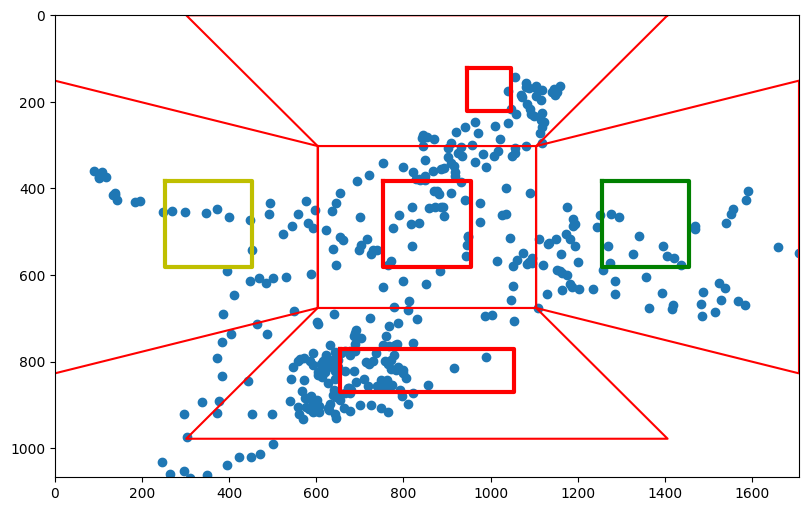

1 unambiguous


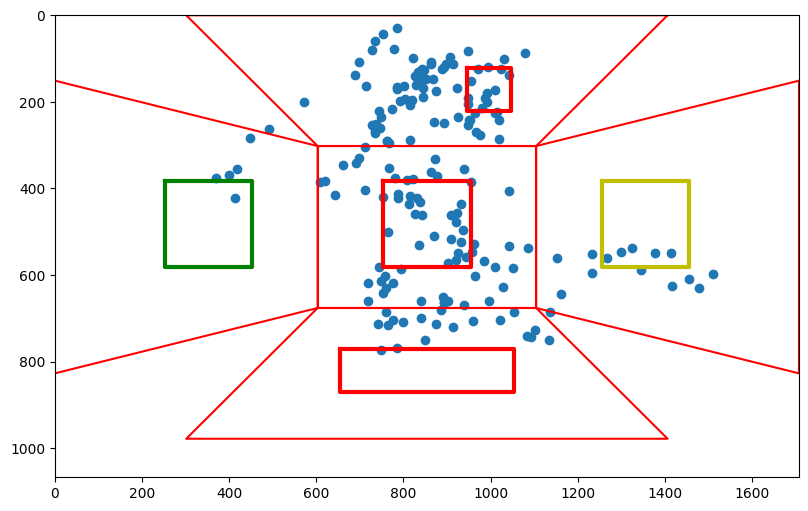

2 simple


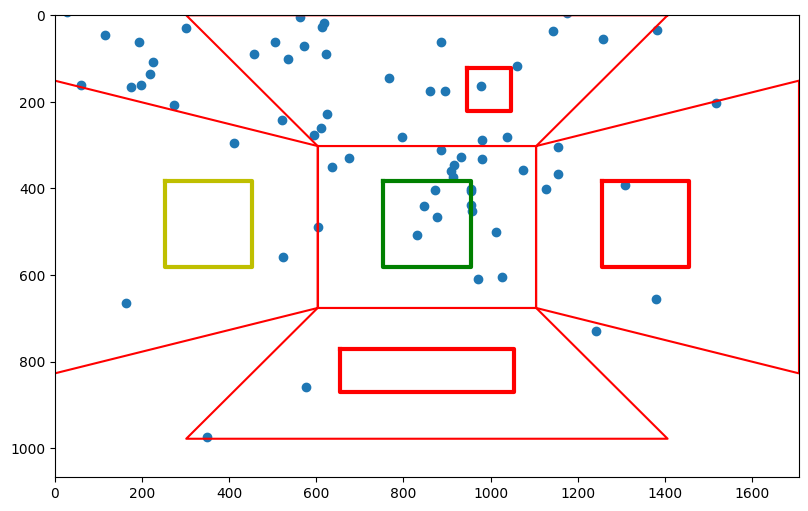

3 complex


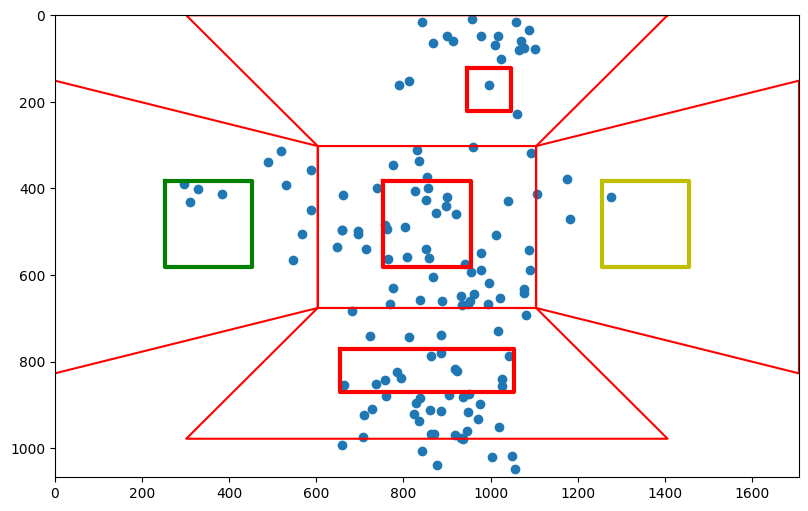

4 unambiguous


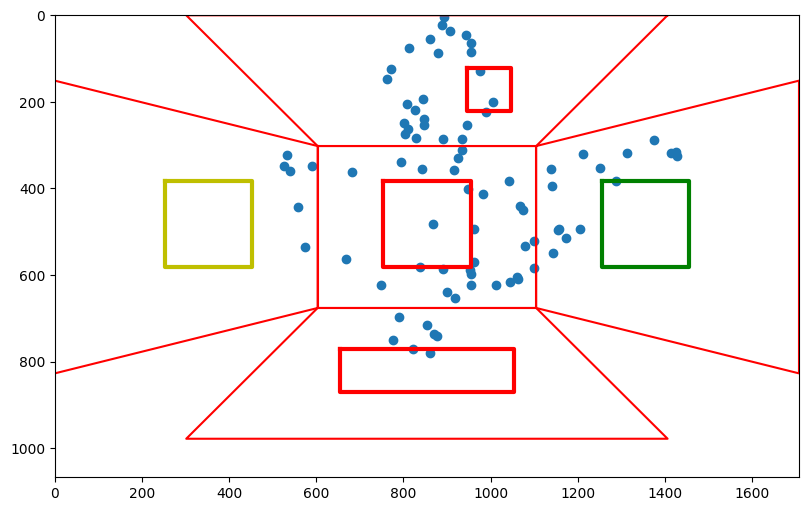

5 simple


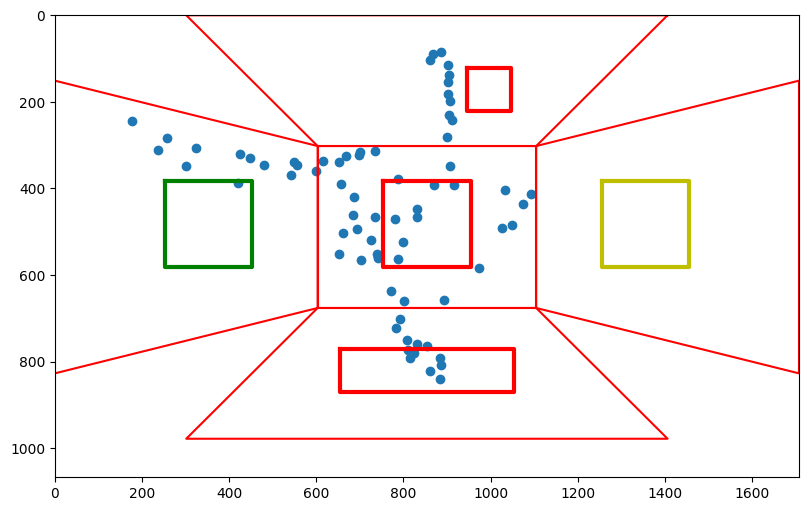

6 simple


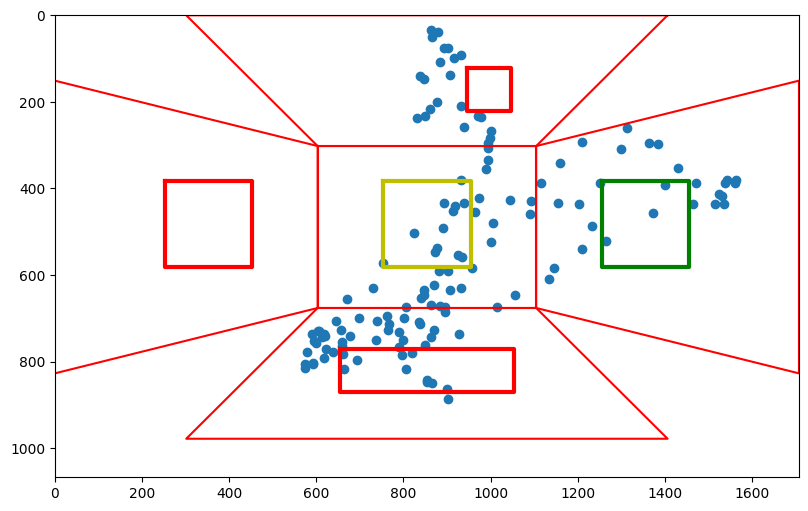

7 unambiguous


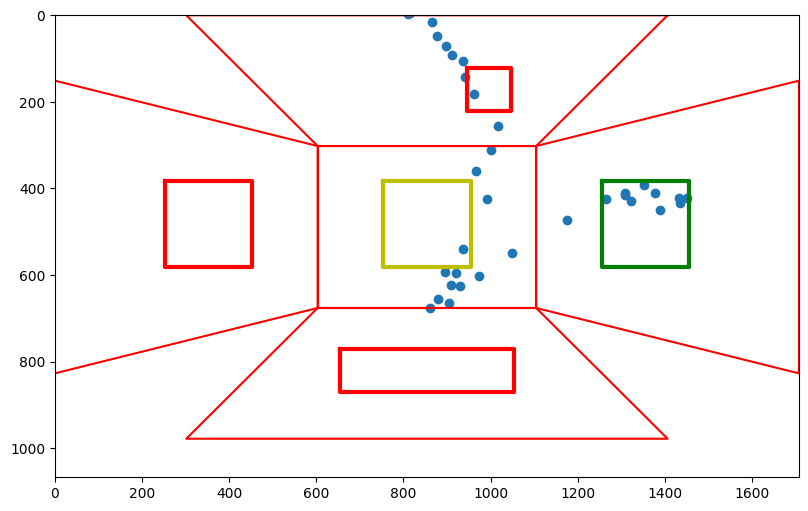

8 complex


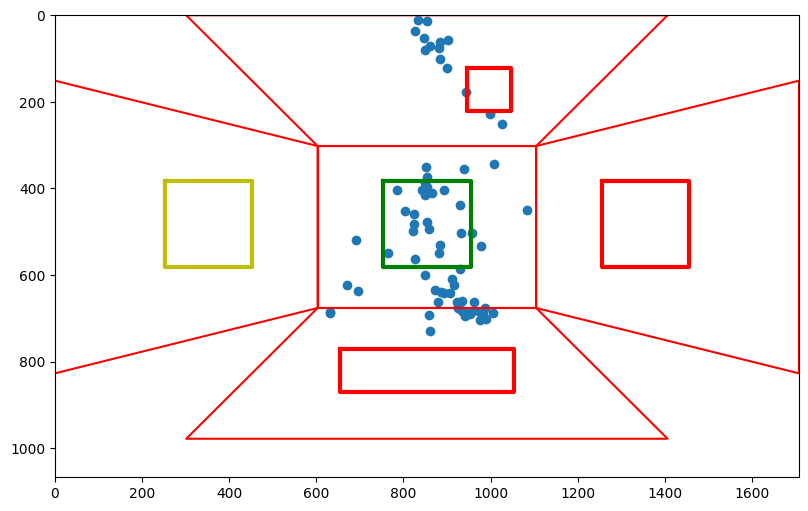

9 unambiguous


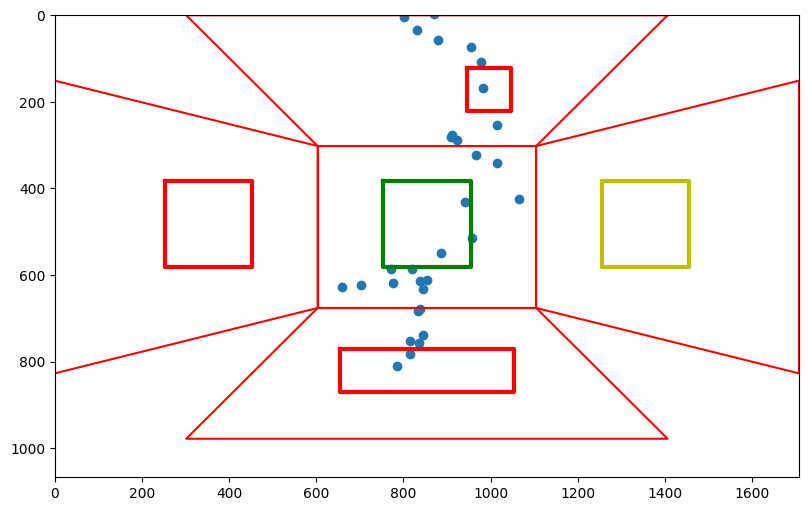

10 simple


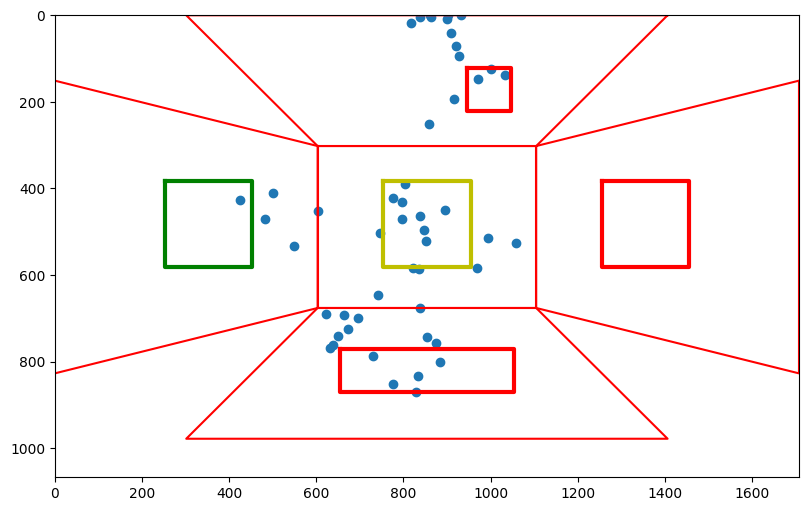

11 complex


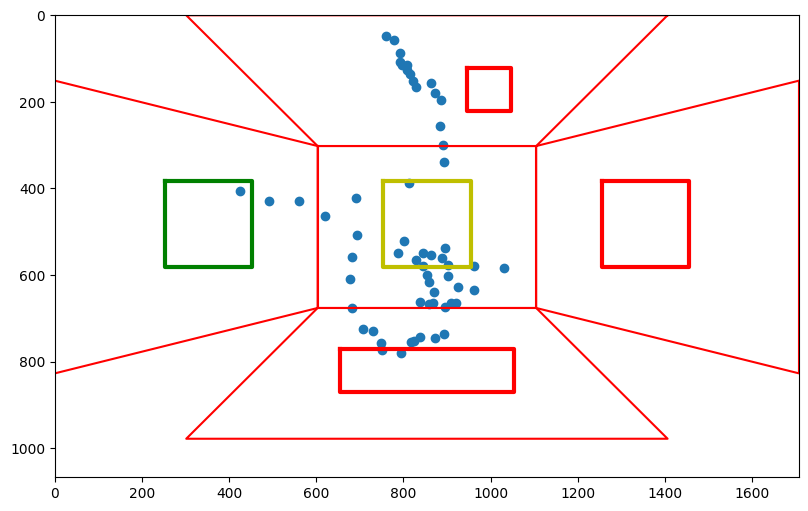

In [15]:
participant = df['workerid'].unique()[3]
print(participant)
sample = df[df['workerid']==participant]
pp.pprint(sample.iloc[0].deviceInfo)
pp.pprint(sample.iloc[0].calibrationPrecision)
resolution = sample.iloc[0].resolution

aoi = ['img1', 'img2', 'img3', 'sent_msg', 'available_msgs']

for i in range(12):
    cur_sample = sample.iloc[i]
    gaze_sample = None
    if use_fixations:
        gaze_sample = cur_sample.fixations
    else:
        gaze_sample = cur_sample.gaze
    x, y = [], []
    if use_fixations:
        x = np.array([f['x'] for f in cur_sample.fixations])
        y = np.array([f['y'] for f in cur_sample.fixations])
    else:
        x = np.array([g['x'] for g in gaze_sample.values()])
        y = np.array([g['y'] for g in gaze_sample.values()])
    # print(len(x))
    # print(cur_sample.answerTime)
    print(i, cur_sample.type)
    # make a scatterplot on the left and a heatmap on the right, keep proportions of the screen
    
    # fig, axs = plt.subplots(1, 2, figsize=(2.2*(resolution[0]*6/resolution[1]), 6))
    plt.figure(figsize=(resolution[0]*6/resolution[1], 6))
    plt.scatter(x, y)
    plt.xlim(0, resolution[0])
    plt.ylim(0, resolution[1])
    plt.gca().invert_yaxis()


    plot_polygons(cur_sample.coordinates, plt)
    for i, area in enumerate(aoi):
        coords = cur_sample.coordinates[area]
        x_min = max(0, coords['x'])
        x_max = coords['x'] + coords['width']
        y_min = max(0, coords['y'])
        y_max = coords['y'] + coords['height']
        # plot boxes around AOI
        color = 'r'
        if cur_sample.trgtPos == i:
            color = 'g'
        if cur_sample.compPos == i:
            color = 'y'
        plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color, linewidth=3)

    plt.show()